### First let's get a time series

In [1]:
import numpy as np
import pandas as pd

from ema import read, smooth

# Read in accelerometer data
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

meal_no = 10  # This one seems reasonable (some are before the start of the accelerometer recording)
samples = read.get_participant_meal(device_id, recording_id, participant_id, meal_no)

# Take one axis for now
accel = samples["accel_x"]

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


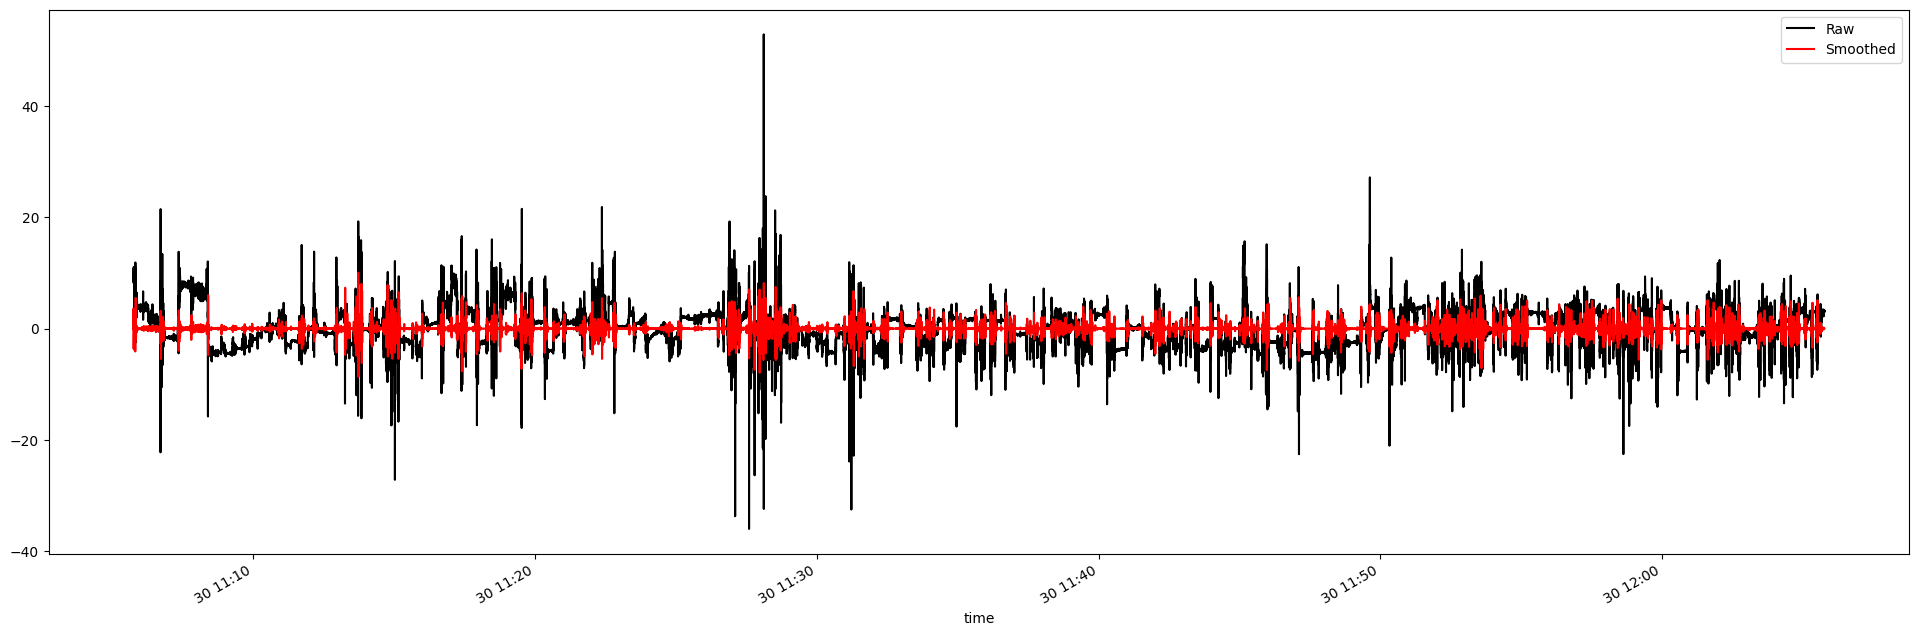

In [2]:
# Filter it
import matplotlib.pyplot as plt

accel -= np.mean(accel)
smoothed_accel= smooth.bandpass_filter(accel, order=3)

# Plot it
fig, ax =plt.subplots(figsize=(24, 8))
accel.plot(ax=ax, color="k", label="Raw")
smoothed_accel.plot(ax=ax, color="r", label="Smoothed")

ax.legend()

### Now let's transform this time series into a form which we can do clustering on

In [3]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from ema import util

# Choose the cluster length
motif_length_sec = 1
motif_length = motif_length_sec * util.SAMPLE_RATE_HZ

# Pad with zeroes to get a time series whose length is a multiple of the motif length
# Pads both front and back of the array
padded_accel: np.ndarray = np.pad(
    smoothed_accel, (0, -len(smoothed_accel) % motif_length), "constant"
)

# Reshape into a matrix of our desired dimension
# For tslearn this should be shape (n, motif_length, d) with dimensionality d=1
padded_accel = padded_accel.reshape(len(padded_accel) // motif_length, motif_length, 1)

# Normalise to have 0 mean and unit variance
padded_accel = TimeSeriesScalerMeanVariance().fit_transform(padded_accel)

/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# Euclidean k-means
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 16
seed = 0
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(padded_accel)

46.894 --> 37.061 --> 35.898 --> 35.477 --> 35.175 --> 34.949 --> 34.785 --> 34.713 --> 34.686 --> 34.671 --> 34.658 --> 34.643 --> 34.636 --> 34.632 --> 34.629 --> 34.624 --> 34.619 --> 34.614 --> 34.611 --> 34.606 --> 34.601 --> 34.599 --> 34.596 --> 34.592 --> 34.590 --> 34.586 --> 34.580 --> 34.575 --> 34.572 --> 34.567 --> 34.561 --> 34.557 --> 34.555 --> 34.552 --> 34.551 --> 34.551 --> 34.551 --> 34.551 --> 


Text(0.5, 0.98, 'Training Data\nEuclidean $k$-means')

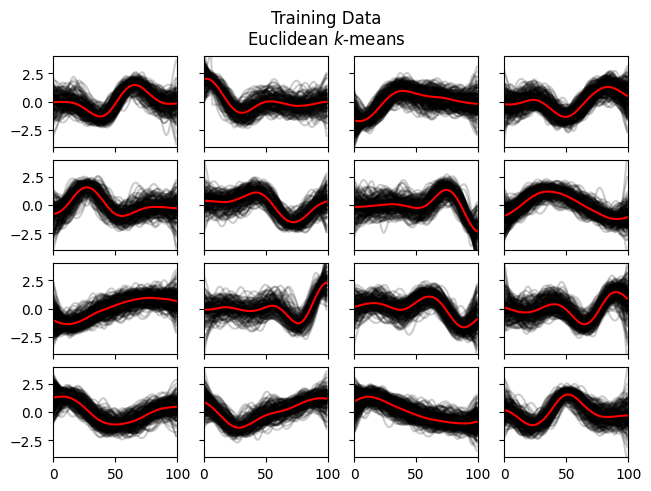

In [5]:
# Plot the discovered motifs and the best fit motif on a grid of axes
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, constrained_layout=True)

for yi, axis in zip(range(n_clusters), axes.ravel()):
    for xx in padded_accel[y_pred == yi]:
        axis.plot(xx.ravel(), "k-", alpha=0.2)
    axis.plot(km.cluster_centers_[yi].ravel(), "r-")
    axis.set_xlim(0, motif_length)
    axis.set_ylim(-4, 4)

fig.suptitle("Training Data\nEuclidean $k$-means")